**Importiere die notwendigen Packages**

In [5]:
#%pip install geopandas fiona requests folium mplleaflet contextily

In [1]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 
import fiona
import requests
import mplleaflet
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [2]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bev_bildungsstand_jahr_aufenthaltsart_od1007

In [6]:
# Filepath
fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bfs_bev_bildungsstand_jahr_aufenthaltsart_od1007/BIL100OD1007.csv"

# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )
print("done")

done


In der Folge ein paar erste Tests:

In [7]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [8]:
data2betested

,Jahr,AufartLang,Bildungsstand,AntBev,untAntBevKI,obAntBevKI
0,2010,Total,Obligatorische Schule,21,21,22
1,2010,Total,Sekundarstufe II,40,39,40
2,2010,Total,Tertiärstufe,39,39,40
3,2010,Schweizer/-innen,Obligatorische Schule,18,17,18
4,2010,Schweizer/-innen,Sekundarstufe II,46,45,46
...,...,...,...,...,...,...
145,2019,Jahresaufenthalter/-innen (B),Sekundarstufe II,16,14,18
146,2019,Jahresaufenthalter/-innen (B),Tertiärstufe,72,70,75
147,2019,Andere,Obligatorische Schule,46,31,62
148,2019,Andere,Sekundarstufe II,16,4,28


In [9]:
data2betested.dtypes

Jahr               int64
AufartLang        object
Bildungsstand     object
AntBev           float64
untAntBevKI      float64
obAntBevKI       float64
dtype: object

In [10]:
data2betested.shape

(150, 6)

Beschreibe einzelne Attribute

In [11]:
data2betested.describe()

,Jahr,AntBev,untAntBevKI,obAntBevKI
count,150,150,150,150
mean,2014,33,30,37
std,3,16,16,17
min,2010,7,0,13
25%,2012,18,16,20
50%,2014,33,29,36
75%,2017,43,41,46
max,2019,74,70,83


Wie viele Nullwerte gibt es im Datensatz?

In [12]:
data2betested.isnull().sum()

Jahr             0
AufartLang       0
Bildungsstand    0
AntBev           0
untAntBevKI      0
obAntBevKI       0
dtype: int64

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [14]:
data2betested['Jahr']=pd.to_datetime(data2betested['Jahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,Jahr,AufartLang,Bildungsstand,AntBev,untAntBevKI,obAntBevKI
0,2010-01-01,Total,Obligatorische Schule,21,21,22
1,2010-01-01,Total,Sekundarstufe II,40,39,40
2,2010-01-01,Total,Tertiärstufe,39,39,40
3,2010-01-01,Schweizer/-innen,Obligatorische Schule,18,17,18
4,2010-01-01,Schweizer/-innen,Sekundarstufe II,46,45,46
...,...,...,...,...,...,...
145,2019-01-01,Jahresaufenthalter/-innen (B),Sekundarstufe II,16,14,18
146,2019-01-01,Jahresaufenthalter/-innen (B),Tertiärstufe,72,70,75
147,2019-01-01,Andere,Obligatorische Schule,46,31,62
148,2019-01-01,Andere,Sekundarstufe II,16,4,28


Bereite die Daten für die Grafik unten vor

In [15]:
Jahre = data2betested.groupby("Jahr")
len(Jahre)

10

In [16]:
for key, group in Jahre:
    print(key, len(group))

2010-01-01 00:00:00 15
2011-01-01 00:00:00 15
2012-01-01 00:00:00 15
2013-01-01 00:00:00 15
2014-01-01 00:00:00 15
2015-01-01 00:00:00 15
2016-01-01 00:00:00 15
2017-01-01 00:00:00 15
2018-01-01 00:00:00 15
2019-01-01 00:00:00 15


In [29]:
myJahr = "2019-01-01"
aktuellesJahr=Jahre.get_group(myJahr)   
aktuellesJahr

,Jahr,AufartLang,Bildungsstand,AntBev,untAntBevKI,obAntBevKI
135,2019-01-01,Total,Obligatorische Schule,15,14,16
136,2019-01-01,Total,Sekundarstufe II,32,31,33
137,2019-01-01,Total,Tertiärstufe,53,52,54
138,2019-01-01,Schweizer/-innen,Obligatorische Schule,14,13,14
139,2019-01-01,Schweizer/-innen,Sekundarstufe II,38,36,39
140,2019-01-01,Schweizer/-innen,Tertiärstufe,49,48,50
141,2019-01-01,Niedergelassene (C),Obligatorische Schule,24,22,26
142,2019-01-01,Niedergelassene (C),Sekundarstufe II,24,22,27
143,2019-01-01,Niedergelassene (C),Tertiärstufe,52,49,54
144,2019-01-01,Jahresaufenthalter/-innen (B),Obligatorische Schule,11,10,13


**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [30]:
#test = data2betested.groupby(['Quartal'])[['stzh_frau']].agg('median')
#test
# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [19]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [40]:
mySelection = data2betested[(data2betested.AufartLang != "Total") & (data2betested.Jahr > "2018")] #data2betested.SteuerTarifLang=="Grundtarif") & 
#mySelection = data2betested[['SteuerJahr', 'QuarLang', 'SteuerEInkommen_p50']]
#selVZA = data2betested[['Jahr', 'Quartal', 'stzh_VZA_Frauen', 'stzh_VZA_Maenner', 'stzh_VZA_s2', 'stzh_VZA_s3']]

mySelection.head()


,Jahr,AufartLang,Bildungsstand,AntBev,untAntBevKI,obAntBevKI
138,2019-01-01,Schweizer/-innen,Obligatorische Schule,14,13,14
139,2019-01-01,Schweizer/-innen,Sekundarstufe II,38,36,39
140,2019-01-01,Schweizer/-innen,Tertiärstufe,49,48,50
141,2019-01-01,Niedergelassene (C),Obligatorische Schule,24,22,26
142,2019-01-01,Niedergelassene (C),Sekundarstufe II,24,22,27


In [41]:
myGraph = mySelection
myGraph.head()


,Jahr,AufartLang,Bildungsstand,AntBev,untAntBevKI,obAntBevKI
138,2019-01-01,Schweizer/-innen,Obligatorische Schule,14,13,14
139,2019-01-01,Schweizer/-innen,Sekundarstufe II,38,36,39
140,2019-01-01,Schweizer/-innen,Tertiärstufe,49,48,50
141,2019-01-01,Niedergelassene (C),Obligatorische Schule,24,22,26
142,2019-01-01,Niedergelassene (C),Sekundarstufe II,24,22,27


In [42]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])
highlight = alt.selection(type='single', on='mouseover',
                          fields=['Bildungsstand'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myGraph).encode(
    x='AufartLang',
    y='AntBev',
    color='Bildungsstand'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

alt.LayerChart(...)

In [47]:
alt.Chart(myGraph).mark_circle(size=60).encode(
    x='AntBev',
    y='AufartLang',
    color='Bildungsstand',
    tooltip=['Jahr','AufartLang','Bildungsstand', 'AntBev','obAntBevKI','untAntBevKI']
).interactive() # this makes the axes interactive: now you can zoom & pan



alt.Chart(...)

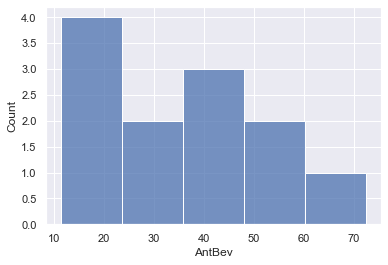

In [48]:
import seaborn as sns
sns.set(style="darkgrid")
sns.histplot(data=myGraph, x="AntBev") #, y="KonOGDKurz")
plt.show();

Hier fertig, keine räumlichen Daten

--------------------------------------------------------------------

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [36]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [48]:
selectMapAttr1 = data2betested[(data2betested.SteuerTarifLang=="Grundtarif") & (data2betested.SteuerJahr == "2018")]
selectMapAttr2 = data2betested[(data2betested.SteuerTarifLang=="Verheiratetentarif") & (data2betested.SteuerJahr == "2018")]


In [49]:
selectMapAttr1.head()


,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerEInkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75
1938,2018-01-01,11,Rathaus,0,Grundtarif,48,19,84
1941,2018-01-01,12,Hochschulen,0,Grundtarif,35,12,73
1944,2018-01-01,13,Lindenhof,0,Grundtarif,52,22,89
1947,2018-01-01,14,City,0,Grundtarif,27,0,73
1950,2018-01-01,21,Wollishofen,0,Grundtarif,44,20,70


In [50]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarSort'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(selectMapAttr1, on='QuarSort')

stadtquartiere_shapes_joined.head(3)


,geometry,QuarSort,qname,knr,SteuerJahr,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerEInkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,2018-01-01,Hirslanden,0,Grundtarif,48,20,81
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2018-01-01,Weinegg,0,Grundtarif,46,16,79
2,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ...",82,Mühlebach,8,2018-01-01,Mühlebach,0,Grundtarif,57,24,98


<AxesSubplot:>

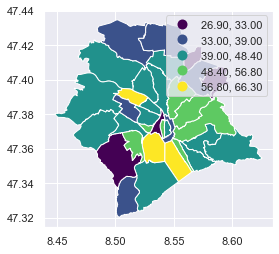

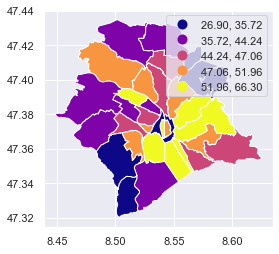

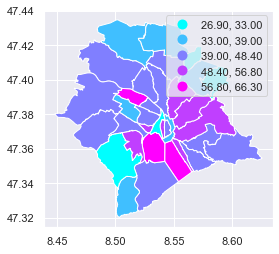

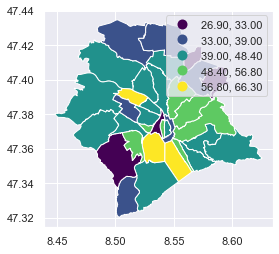

In [51]:
# Plot by StatQuartiere

stadtquartiere_shapes_joined.plot(column='SteuerEInkommen_p50', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='SteuerEInkommen_p50', cmap='plasma', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='SteuerEInkommen_p50', cmap='cool', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='SteuerEInkommen_p50', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

----------------------------------------------------------------------------------------

#Link https://automating-gis-processes.github.io/site/notebooks/L5/interactive-map-folium.html

# Create a Map instance
m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)

# Plot a choropleth map
# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column
folium.Choropleth(
    geo_data=data,
    name='Population in 2018',
    data=data,
    columns=['geoid', 'pop18'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='white',
    line_weight=0,
    highlight=False,
    smooth_factor=1.0,
    #threshold_scale=[100, 250, 500, 1000, 2000],
    legend_name= 'Population in Helsinki').add_to(m)

#Show map
m

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html